In [1]:
import os 
import pandas as pd
import re
import matplotlib.pyplot as plt
import csv

In [2]:
from google.cloud import bigquery

In [3]:
from datetime import timedelta

In [4]:
project_id = 'your-project-here'

In [5]:
BigQuery_client = bigquery.Client(project=project_id)

In [6]:
# This is a practice query to ensure you can pull a short query from lcp-consortium
practice = '''SELECT * FROM `lcp-consortium.mimiciv_note.radiology` LIMIT 10;'''

In [7]:
# Put the short practice query into a dataframe
dfpractice = BigQuery_client.query(practice).to_dataframe()
dfpractice.head()

,note_id,subject_id,hadm_id,note_type,note_seq,charttime,storetime,text
0,17693798-RR-256,17693798,26855677,RR,256,2125-05-20 21:00:00,2125-05-21 10:03:00,CLINICAL HISTORY: Patient fell onto right rib...
1,12165964-RR-256,12165964,29176015,RR,256,2152-07-01 03:52:00,2152-07-01 12:57:00,AP CHEST 4:52 A.M. ON ___\n\nHISTORY: CHF and...
2,17329106-RR-256,17329106,23935599,RR,256,2158-08-20 19:36:00,2158-08-20 21:16:00,HISTORY: Altered mental status.\n\nCOMPARISON...
3,16921793-RR-256,16921793,23285822,RR,256,2134-05-01 07:12:00,2134-05-01 08:57:00,INDICATION: History of end-stage renal diseas...
4,14867101-RR-257,14867101,24955503,RR,257,2151-01-28 18:42:00,2151-01-28 19:52:00,CHEST RADIOGRAPH\n\nComparison is made with a ...


In [8]:
# I want to pull in all EKG images available from MIMIC-CXR
EKG = '''--CTE for ekg_note table
WITH ekg_note AS
(SELECT note_id, subject_id, hadm_id, text
FROM `lcp-consortium.mimiciv_note.ecg`),

--CTE for ekg table
ekg AS
(SELECT subject_id, study_id, file_name, ecg_time, path
FROM `physionet-data.mimiciv_ecg.record_list`),

--CTE for waveform table
waveform AS 
(SELECT study_id, note_id
FROM `physionet-data.mimiciv_ecg.waveform_note_links`)

SELECT * FROM ekg
LEFT JOIN waveform
ON ekg.study_id = waveform.study_id
LEFT JOIN ekg_note
ON waveform.note_id = ekg_note.note_id'''

In [9]:
EKG = BigQuery_client.query(EKG).to_dataframe()

In [10]:
len(EKG)

800042

In [11]:
EKG.head()

,subject_id,study_id,file_name,ecg_time,path,study_id_1,note_id,note_id_1,subject_id_1,hadm_id,text
0,10000032,40689238,40689238,2180-07-23 08:44:00,files/p1000/p10000032/s40689238/40689238,40689238.0,10000032-EK-4,10000032-EK-4,10000032.0,NaN,Sinus rhythm. Biatrial abnormality. Intraven...
1,10000032,44458630,44458630,2180-07-23 09:54:00,files/p1000/p10000032/s44458630/44458630,44458630.0,10000032-EK-5,10000032-EK-5,10000032.0,NaN,Sinus rhythm. Biatrial abnormality. Intraven...
2,10000032,49036311,49036311,2180-08-06 09:07:00,files/p1000/p10000032/s49036311/49036311,49036311.0,10000032-EK-6,10000032-EK-6,10000032.0,25742920.0,Sinus tachycardia. Compared to the ___ the fi...
3,10000560,41445586,41445586,2189-10-03 12:54:00,files/p1000/p10000560/s41445586/41445586,41445586.0,10000560-EK-12,10000560-EK-12,10000560.0,NaN,Sinus rhythm. Rightward axis is non-specific a...
4,10000635,40067704,40067704,2136-06-19 07:24:00,files/p1000/p10000635/s40067704/40067704,40067704.0,10000635-EK-12,10000635-EK-12,10000635.0,NaN,Sinus rhythm. Left ventricular hypertrophy. ...


In [25]:
# How many unique values are there in study_id in the EKG dataframe?
unique_studyid = EKG['study_id'].nunique()
print("Number of unique study IDs:", unique_studyid)

Number of unique study IDs: 800035


In [12]:
# Import the file of all CTPAs, including both positive and negative PE
AllCTPA = pd.read_csv("/Users/Desktop/CXRPE/AllCTPA.csv")

In [13]:
len(AllCTPA)

17417

In [14]:
# Merge the EKG dataframe with the dataframe containing all CTPAs
EKGallCTA = AllCTPA.merge(EKG, on='subject_id', how='left')
len(EKGallCTA)

216681

In [17]:
# Make a copy to work with datetime
EKGtoallCTA = EKGallCTA.copy()

In [18]:
# Ensure everything is in datetime format
EKGtoallCTA['charttime'] = pd.to_datetime(EKGtoallCTA['charttime'])
EKGtoallCTA['storetime'] = pd.to_datetime(EKGtoallCTA['storetime'])
EKGtoallCTA['ecg_time'] = pd.to_datetime(EKGtoallCTA['ecg_time'])

In [19]:
# Calculate time difference between EKG time and CTA order time 
EKGtoallCTA['EKGtoCTA'] = EKGtoallCTA['ecg_time'] - EKGtoallCTA['charttime']

In [20]:
# Create a new column that is the time difference in hours
EKGtoallCTA['time_elapsed_hours'] = EKGtoallCTA['EKGtoCTA'].dt.total_seconds()/3600

In [21]:
# Create a new column that evalutes to true if the time difference is within 24 hours
EKGtoallCTA['within_24'] = abs(EKGtoallCTA['time_elapsed_hours']) <= 24

In [22]:
# Create a new column that evalutes to true if the time difference is 24 hours before and up to 48 hours after
EKGtoallCTA['and_48_hours'] = (EKGtoallCTA['time_elapsed_hours'] >= -24) & (EKGtoallCTA['time_elapsed_hours'] <= 48)

In [23]:
# How many EKGs are there within 24 hours? 
EKG_within_24h = EKGtoallCTA['within_24'].sum()
print("Number of True values in 'within_24' column:", EKG_within_24h)

Number of True values in 'within_24' column: 17529


In [24]:
# How many CXRs are there within -24 hours and +48 hours?
EKG_within_48h = EKGtoallCTA['and_48_hours'].sum()
print("Number of True values in 'and_48_hours' column:", EKG_within_48h)

Number of True values in 'and_48_hours' column: 19211


In [30]:
# Can we convert the amount of time between CXR to CTA to days so that we can see a histogram of the distribution
EKGtoallCTA['time_elapsed_days'] = EKGtoallCTA['EKGtoCTA'].dt.days

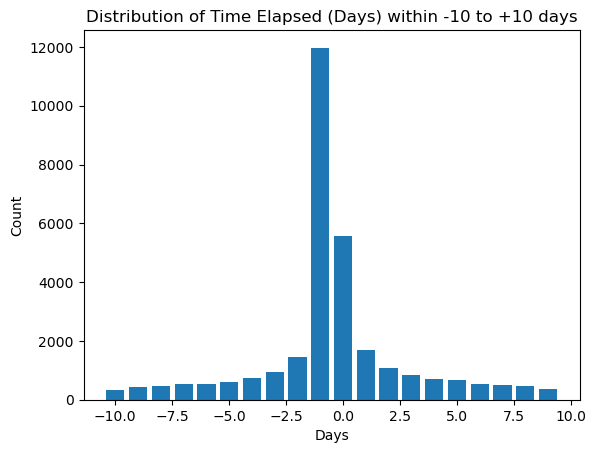

In [31]:
# Define the range for x-axis ticks (-10 to +10 days)
x_ticks_range = range(-10, 10)

# Count the occurrences of each day within the specified range
day_counts = EKGtoallCTA['time_elapsed_days'].value_counts().reindex(x_ticks_range, fill_value=0)

# Plotting the bar graph
plt.bar(day_counts.index, day_counts.values)

# Adding labels and title
plt.xlabel('Days')
plt.ylabel('Count')
plt.title('Distribution of Time Elapsed (Days) within -10 to +10 days')

# Display the plot
plt.show()

In [32]:
## Code below here deals with CTAs that are POSITIVE for PE only

In [33]:
# Import the file of positive CTPAs only
PosCTA = pd.read_csv("/Users/Desktop/CXRPE/PosPE.csv")

In [34]:
len(PosCTA)

1531

In [35]:
EKGposCTA = PosCTA.merge(EKG, on='subject_id', how='left')

In [36]:
# Ensure everything is in datetime format
EKGposCTA['charttime'] = pd.to_datetime(EKGposCTA['charttime'])
EKGposCTA['storetime'] = pd.to_datetime(EKGposCTA['storetime'])
EKGposCTA['ecg_time'] = pd.to_datetime(EKGposCTA['ecg_time'])

In [37]:
# Calculate time difference between EKG time and CTA order time 
EKGposCTA['EKGtoCTA'] = EKGposCTA['ecg_time'] - EKGposCTA['charttime']

In [38]:
# Create a new column that is the time difference in hours
EKGposCTA['time_elapsed_hours'] = EKGposCTA['EKGtoCTA'].dt.total_seconds()/3600

In [39]:
# Create a new column that evalutes to true if the time difference is within 24 hours
EKGposCTA['within_24'] = abs(EKGposCTA['time_elapsed_hours']) <= 24

In [40]:
# Create a new column that evalutes to true if the time difference is 24 hours before and up to 48 hours after
EKGposCTA['and_48_hours'] = (EKGposCTA['time_elapsed_hours'] >= -24) & (EKGposCTA['time_elapsed_hours'] <= 48)

In [47]:
# Create a dataframe that only includes EKGs within 24 hours of positive CTAs
EKGposCTA24 = EKGposCTA[EKGposCTA['within_24']]

In [48]:
# How many unique values are there in study_id in this 24h dataframe?
EKGposCTA24unique = EKGposCTA24['study_id'].nunique()
print("Number of unique study IDs:", EKGposCTA24unique)

Number of unique study IDs: 1481


In [41]:
# Create a dataframe that only includes EKGs that are within -24h and +48h of positive CTAs
EKGposCTA48 = EKGposCTA[EKGposCTA['and_48_hours']]

In [49]:
# How many unique values are there in study_id in this -24h to +48h dataframe?
EKGposCTA48unique = EKGposCTA48['study_id'].nunique()
print("Number of unique study IDs:", EKGposCTA48unique)

Number of unique study IDs: 1676


In [77]:
# Export for modeling
EKGposCTA48.to_csv('/Users/Desktop/CXRPE/Modeling/EKGpos48.csv', index=False)

In [50]:
## Code below here deals with CTAs that show negative PEs only

In [51]:
# Import the file of negative CTPAs only
NegCTA = pd.read_csv("/Users/Desktop/CXRPE/NegPE.csv")

In [52]:
len(NegCTA)

15886

In [53]:
EKGnegCTA = NegCTA.merge(EKG, on='subject_id', how='left')

In [54]:
# Ensure everything is in datetime format
EKGnegCTA['charttime'] = pd.to_datetime(EKGnegCTA['charttime'])
EKGnegCTA['storetime'] = pd.to_datetime(EKGnegCTA['storetime'])
EKGnegCTA['ecg_time'] = pd.to_datetime(EKGnegCTA['ecg_time'])

In [55]:
# Calculate time difference between EKG time and CTA order time 
EKGnegCTA['EKGtoCTA'] = EKGnegCTA['ecg_time'] - EKGnegCTA['charttime']

In [56]:
# Create a new column that is the time difference in hours
EKGnegCTA['time_elapsed_hours'] = EKGnegCTA['EKGtoCTA'].dt.total_seconds()/3600

In [57]:
# Create a new column that evalutes to true if the time difference is within 24 hours
EKGnegCTA['within_24'] = abs(EKGnegCTA['time_elapsed_hours']) <= 24

In [58]:
# Create a new column that evalutes to true if the time difference is 24 hours before and up to 48 hours after
EKGnegCTA['and_48_hours'] = (EKGnegCTA['time_elapsed_hours'] >= -24) & (EKGnegCTA['time_elapsed_hours'] <= 48)

In [59]:
# Create a dataframe that only includes EKGs within 24 hours of positive CTAs
EKGnegCTA24 = EKGnegCTA[EKGnegCTA['within_24']]

In [60]:
# How many unique values are there in study_id in this 24h dataframe?
EKGnegCTA24unique = EKGnegCTA24['study_id'].nunique()
print("Number of unique study IDs:", EKGnegCTA24unique)

Number of unique study IDs: 16026


In [61]:
# Create a dataframe that only includes EKGs that are within -24h and +48h of positive CTAs
EKGnegCTA48 = EKGnegCTA[EKGnegCTA['and_48_hours']]

In [62]:
# How many unique values are there in study_id in this -24h to +48h dataframe?
EKGnegCTA48unique = EKGnegCTA48['study_id'].nunique()
print("Number of unique study IDs:", EKGnegCTA48unique)

Number of unique study IDs: 17504


In [78]:
# Export for modeling
EKGnegCTA48.to_csv('/Users/Desktop/CXRPE/Modeling/EKGneg48.csv', index=False)

In [63]:
## The below is an accuracy check

In [75]:
# Check to see if there are any overlapping study_id between the positives and negatives
# Start by vertically concatenating the two dataframes
PosAndNeg48EKG = pd.concat([EKGposCTA48, EKGnegCTA48], ignore_index=True)

In [76]:
# Are there any duplicate study IDs?
study_dupes = PosAndNeg48EKG[PosAndNeg48EKG.duplicated(subset=['study_id'], keep=False)]

In [73]:
# Export to evaluate
study_dupes.to_csv('/Users/Desktop/CXRPE/Modeling/ekgdupe.csv', index=False)